In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import optuna 
import logging
from datetime import timedelta, datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from concurrent.futures import ThreadPoolExecutor

# Configuración de logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
proporcion_entrenamiento = 0.80
horizon_months = 1
fourier_order = 4

Y_df_grouped = Y_df.groupby('unique_id')

In [4]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para realizar la optimización con Optuna
def optimize_prophet(trial, ts_prophet, training_duration, horizon):
    param_grid = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95)
    }

    model = Prophet(**param_grid, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.8)
    model.add_country_holidays(country_name='US')

    model.fit(ts_prophet)
    df_cv_model = cross_validation(model, initial=timedelta(days=training_duration), horizon=timedelta(days=horizon), disable_tqdm=True, parallel='threads')
    df_metrics = performance_metrics(df_cv_model)

    smape_score = (df_metrics.groupby('horizon').mean())['smape'].mean()
    mape_score = (df_metrics.groupby('horizon').mean())['mape'].mean()
    mse_score = (df_metrics.groupby('horizon').mean())['mse'].mean()
    rmse_score = (df_metrics.groupby('horizon').mean())['rmse'].mean()
    mae_score = (df_metrics.groupby('horizon').mean())['mae'].mean()

    trial.set_user_attr("mape_score", mape_score)
    trial.set_user_attr("mse_score", mse_score)
    trial.set_user_attr("rmse_score", rmse_score)
    trial.set_user_attr("mae_score", mae_score)

    return smape_score

In [5]:
def forecast_for_Ticker(id, ts, horizon_months, proporcion_entrenamiento):
    try:
        start_time = time.time()  # Inicia el cronómetro

        # Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento)
        ts_entrenamiento = ts[:indice_entrenamiento]
        ts_validacion = ts[indice_entrenamiento:]
        ts_prophet = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo Prophet
        training_duration_days = len(ts_entrenamiento) * 30.5
        horizon_days = horizon_months * 30.5 # Si fuera month sería 30.5

        # Optimización de parámetros
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_prophet(trial, ts_prophet, training_duration_days, horizon_days), n_trials=30, n_jobs=-1, timeout=180)

        smape_score = study.best_value
        accuracy = round((1 - smape_score)*100, 2) if smape_score < 1 else 0.00

        mape_score = study.best_trial.user_attrs["mape_score"]
        mse_score = study.best_trial.user_attrs["mse_score"]
        rmse_score = study.best_trial.user_attrs["rmse_score"]
        mae_score = study.best_trial.user_attrs["mae_score"]
        best_params = study.best_trial.params

        model = Prophet(**best_params, interval_width=0.8)
        model.add_country_holidays(country_name='US')

        model.fit(ts_prophet)
        future = model.make_future_dataframe(periods=horizon_months, freq="MS", include_history=False)
        forecast = model.predict(future)

        end_time = time.time()
        forecast_duration = end_time - start_time

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy,
            'smape': smape_score,
            'mape': mape_score,
            'mae': mae_score,
            'mse': mse_score,
            'rmse': rmse_score,
            'forecast_duration_seconds': forecast_duration
        }

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')
    except Exception as e:
        logging.error(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None

# Ejecución en paralelo
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(forecast_for_Ticker, id, ts, horizon_months, proporcion_entrenamiento) for id, ts in Y_df_grouped]
    for future in futures:
        try:
            result = future.result()
            if result is not None:
                resultado_accuracy, forecast_records = result
                if resultado_accuracy is not None:
                    modelo_precision_forecast_list.append(resultado_accuracy)
                    print(f"SMAPE: {resultado_accuracy.get('smape'):.2f}, MAPE: {resultado_accuracy.get('mape'):.2f}, MAE: {resultado_accuracy.get('mae'):.2f}, MSE: {resultado_accuracy.get('mse'):.2f}, RMSE: {resultado_accuracy.get('rmse'):.2f}, Forecast Duration: {resultado_accuracy.get('forecast_duration_seconds'):.2f} seconds")
                if forecast_records is not None:
                    forecast_result_list.extend(forecast_records)
        except Exception as e:
            print(f'Error processing future: {e}')

SMAPE: 0.17, MAPE: 0.16, MAE: 20.72, MSE: 683.75, RMSE: 25.21, Forecast Duration: 1249.12 seconds
SMAPE: 0.17, MAPE: 0.17, MAE: 24.23, MSE: 885.51, RMSE: 28.55, Forecast Duration: 1226.58 seconds
SMAPE: 0.37, MAPE: 0.42, MAE: 13949.10, MSE: 280263408.00, RMSE: 16503.48, Forecast Duration: 672.82 seconds
SMAPE: 0.23, MAPE: 0.21, MAE: 26.33, MSE: 872.69, RMSE: 28.56, Forecast Duration: 1203.39 seconds
SMAPE: 0.08, MAPE: 0.08, MAE: 10.25, MSE: 211.59, RMSE: 13.26, Forecast Duration: 1232.60 seconds
SMAPE: 0.42, MAPE: 0.34, MAE: 84.58, MSE: 11581.09, RMSE: 106.08, Forecast Duration: 822.88 seconds
SMAPE: 0.10, MAPE: 0.10, MAE: 28.09, MSE: 1389.12, RMSE: 33.73, Forecast Duration: 1229.73 seconds
SMAPE: 0.36, MAPE: 0.33, MAE: 10.92, MSE: 330.46, RMSE: 14.22, Forecast Duration: 1247.01 seconds


In [6]:
modelo_precision_forecast_list = [item for item in modelo_precision_forecast_list if item is not None]
forecast_result_list = [item for item in forecast_result_list if item is not None]

# Crear los dataframes pandas de los resultados
modelo_precision_forecast = pd.DataFrame(modelo_precision_forecast_list)
forecast_result = pd.DataFrame(forecast_result_list)

In [14]:
forecast_result

,ticker,ds,yhat
0,AAPL,01-11-2024,209.29
1,AMZN,01-11-2024,160.05
2,BTC-USD,01-11-2024,46142.72
3,GOOGL,01-11-2024,151.92
4,IBM,01-11-2024,190.88
5,META,01-11-2024,548.81
6,MSFT,01-11-2024,460.35
7,NVDA,01-11-2024,93.40


In [7]:
modelo_precision_forecast

,ticker,accuracy,smape,mape,mae,mse,rmse,forecast_duration_seconds
0,AAPL,83.33,0.166692,0.161010,20.716061,6.837481e+02,25.207453,1249.117403
1,AMZN,82.74,0.172571,0.173675,24.234178,8.855094e+02,28.549191,1226.575531
2,BTC-USD,63.04,0.369606,0.424147,13949.104663,2.802634e+08,16503.475759,672.823962
3,GOOGL,76.82,0.231776,0.211958,26.328317,8.726910e+02,28.557904,1203.394389
4,IBM,91.91,0.080910,0.077383,10.246847,2.115867e+02,13.255606,1232.595150
5,META,58.18,0.418161,0.339385,84.580540,1.158109e+04,106.079009,822.876830
6,MSFT,89.89,0.101125,0.101544,28.088960,1.389122e+03,33.733784,1229.728888
7,NVDA,64.35,0.356518,0.327968,10.923313,3.304605e+02,14.220095,1247.010466


In [12]:
import matplotlib.pyplot as plt

def plot_prophet_predictions(ticker, forecast, Y_df):
    # Filtrar los datos reales (históricos) para el ticker específico
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Asegurarse de que la columna 'ds' está en formato datetime en ambos DataFrames
    Y_df_ticker['ds'] = pd.to_datetime(Y_df_ticker['ds'])
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # Graficar
    plt.figure(figsize=(12, 6))

    # Datos reales (históricos)
    real_series = Y_df_ticker[['ds', 'y']]
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predicciones (forecast de Prophet)
    plt.plot(forecast['ds'], forecast['yhat'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Configuración del gráfico
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Focalizar en la zona de predicción: mostrar solo las fechas de predicción
    min_prediction_date = forecast['ds'].min() - pd.DateOffset(months=1)
    max_prediction_date = forecast['ds'].max() + pd.DateOffset(months=1)
    plt.xlim([min_prediction_date, max_prediction_date])

    # Mostrar una cuadrícula
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()


Graficando las predicciones para AAPL...


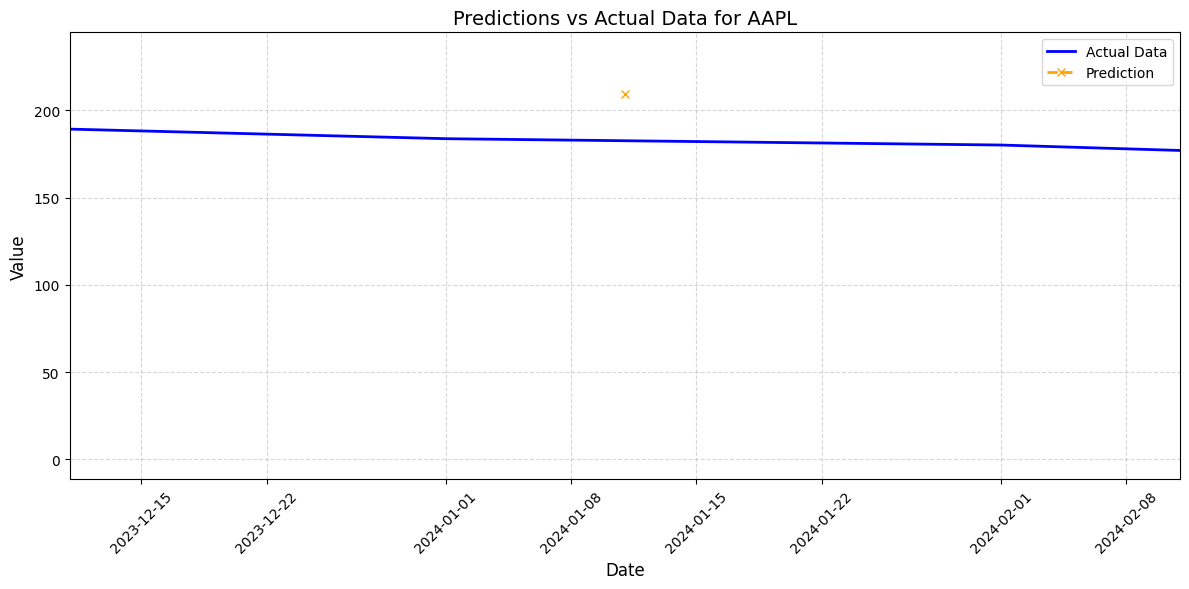


Graficando las predicciones para AMZN...


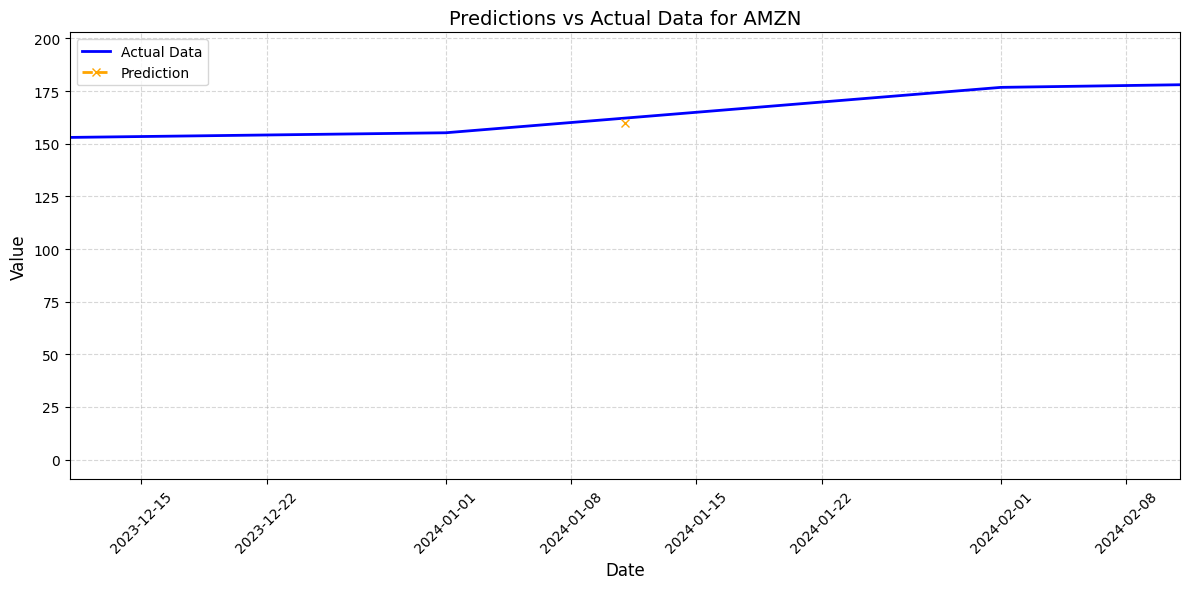


Graficando las predicciones para BTC-USD...


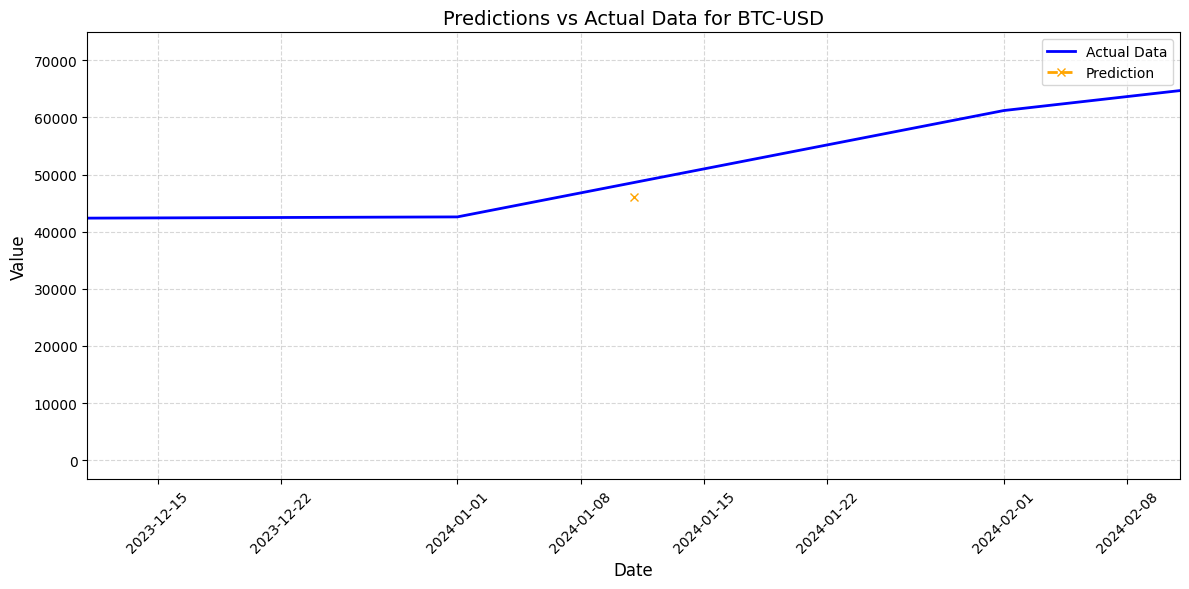


Graficando las predicciones para GOOGL...


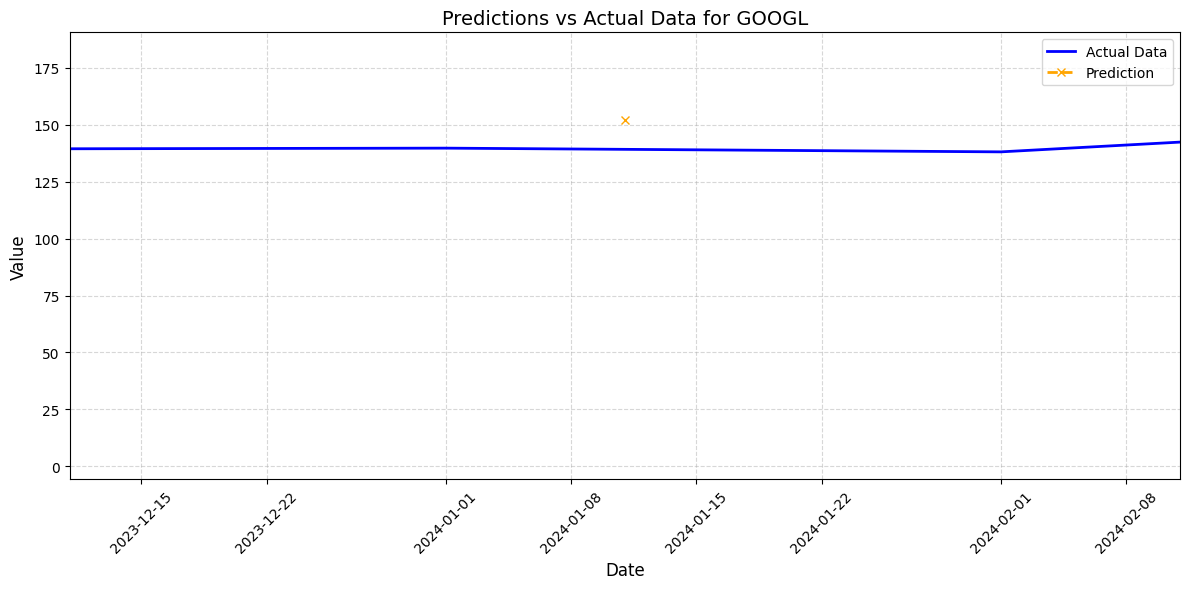


Graficando las predicciones para IBM...


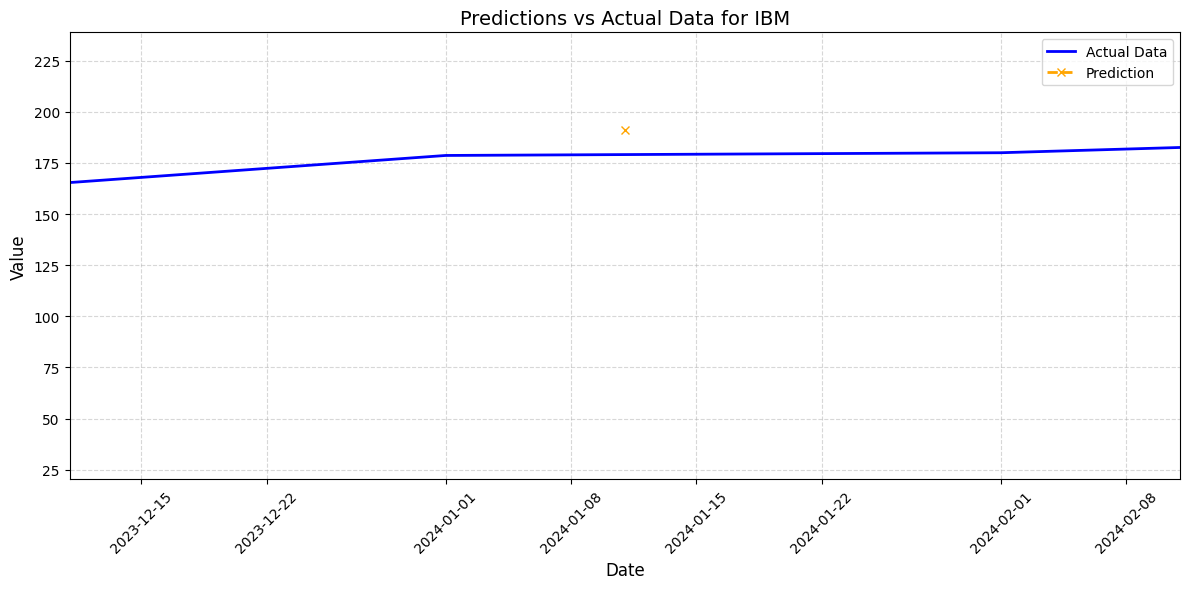


Graficando las predicciones para META...


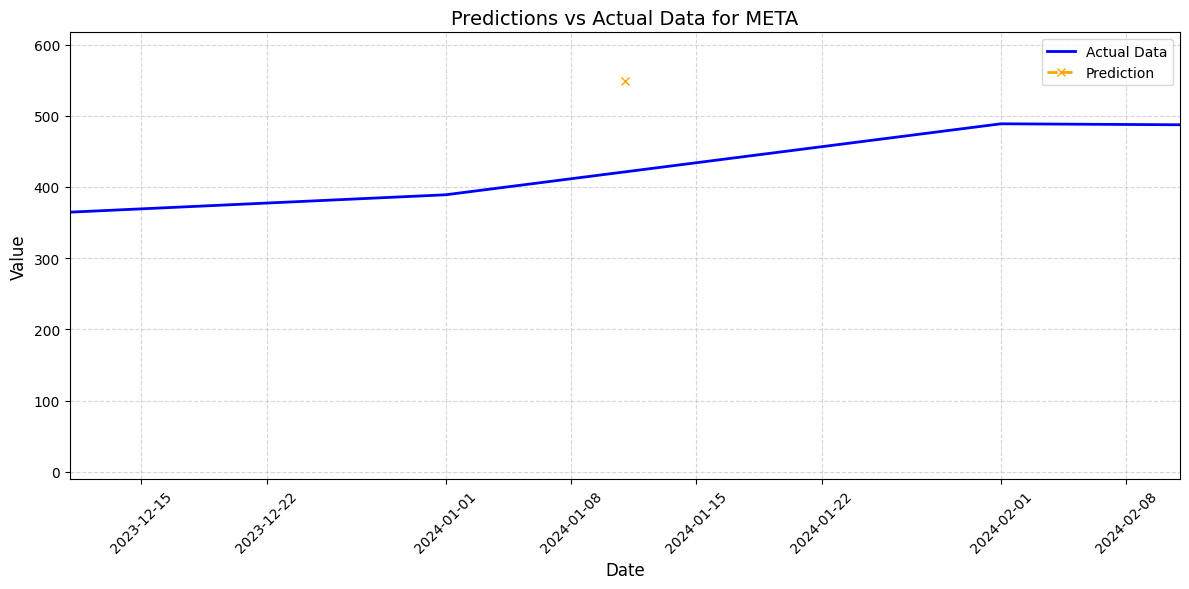


Graficando las predicciones para MSFT...


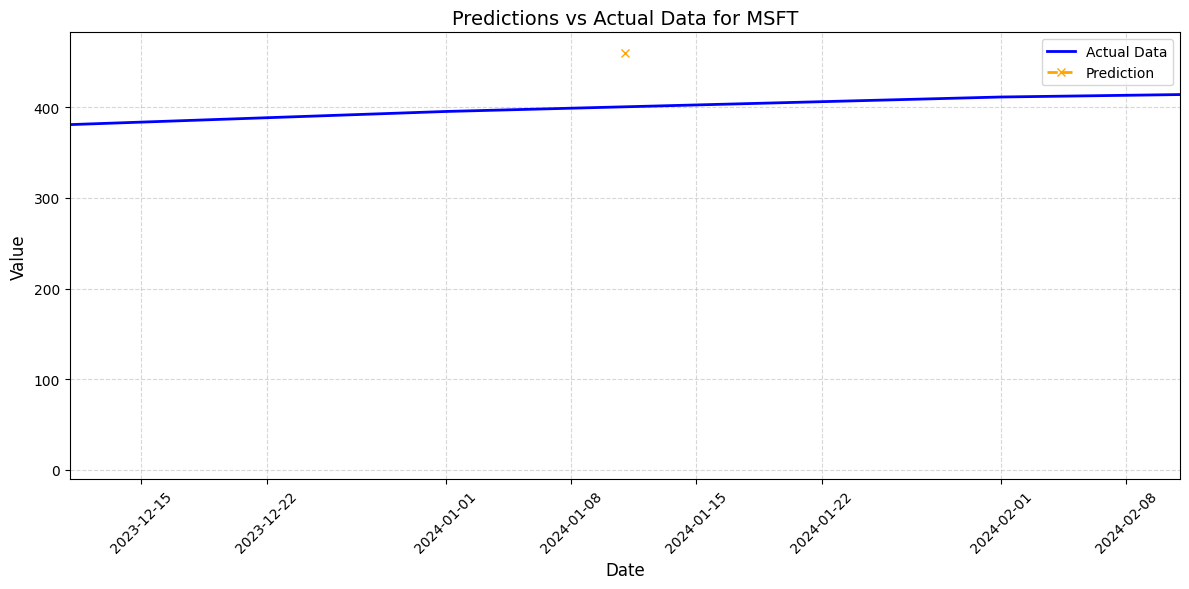


Graficando las predicciones para NVDA...


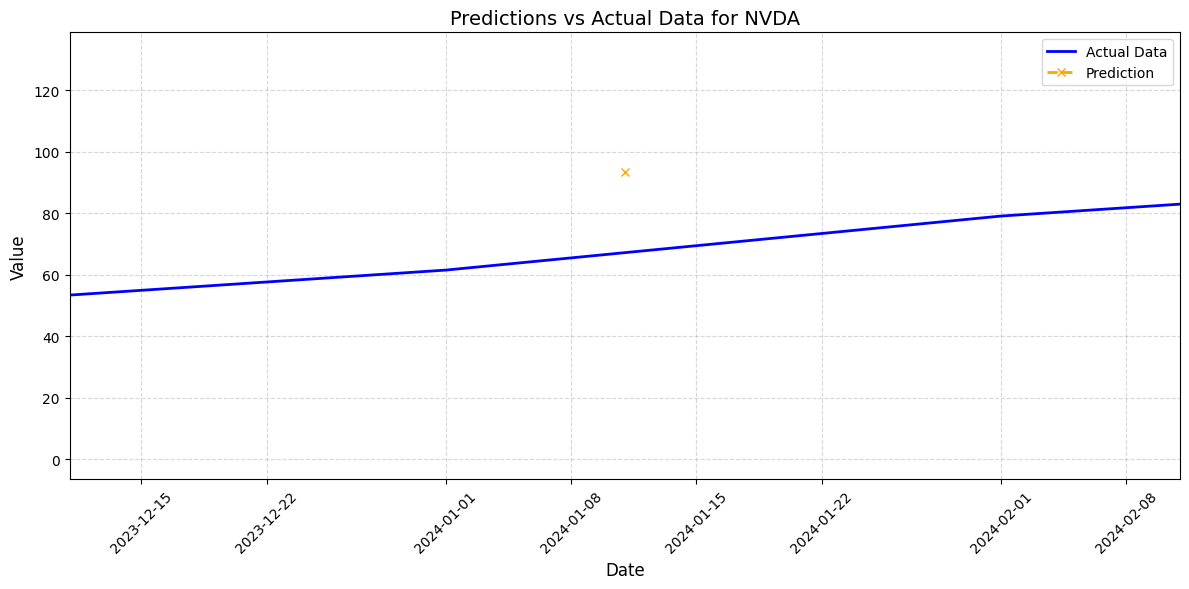

In [13]:
# Graficar resultados para cada ticker
for ticker in Y_df['unique_id'].unique():
    print(f"\nGraficando las predicciones para {ticker}...")

    # Filtrar las predicciones para el ticker actual
    forecast_ticker = forecast_result[forecast_result['ticker'] == ticker]
    
    # Llamar a la función de graficación
    plot_prophet_predictions(ticker, forecast_ticker, Y_df)